# Post-impact disk finder tutorial

This is a demonstration version of the disk finding algorithm that was used in Timpe et al. (2023). It can be used on post-impact snapshots of smoothed-particle hydrodynamics simulations (e.g., Gasoline) to differentiate the post-impact planet from the circumplanetary disk and ejecta. Note that the algorithm assumes that sufficient time has passed since the impact for the system to settle into a coherent central body and circumplanetary disk.

Authors: Miles Timpe (mtimpe@me.com), Christian Reinhardt (christian.reinhardt@ics.uzh.ch), Thomas Meier (thomas.meier5@uzh.ch), Joachim Stadel (stadel@physik.uzh.ch), Ben Moore (ben.moore@uzh.ch)

Date: 20 September, 2023

### Import libraries

In [1]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pynbody

import constants as C

from utils import angular_momentum, angular_momentum_vector
from utils import orbital_velocity, rotation_period
from utils import cart2kep

### Functions

In [2]:
def center_on_largest_remnant(coll, rho_perc=85.0):
    """Centers snapshot on core of the largest remnant.

    Calculates the center of mass for all particles with PIDs in the provided
    list and with a density above the 'rho_cut' threshold. The
    threshold is determined by the percentile 'rho_perc', which should isolate
    only the dense core of the main fragment. This should work in the case of
    two large post-impact fragments (e.g., a hit-and-run).

    Args:
        coll (pynbody):   Snapshot to be centered.
        rho_perc (float): Calculate center of mass using only particles with
                          densities above this percentile.

    Returns:
        pynbody: Centered snapshot.

    """

    # Find the highest density point in the snapshot. This should correspond to
    # the center of the planet. 
    LR = coll.load_copy()

    rho_cut = np.percentile(LR['rho'].in_units('g cm**-3'), rho_perc)

    LR = LR[LR['rho'].in_units('g cm**-3') > rho_cut]


    # [WARNING] Using the mean/average means that a single dense particle at a
    # large distance can significantly affect the COM position. Using the median
    # is a robust alternative.
    xcm = float(np.average(np.array(LR['pos'])[:,0],
                weights=LR['mass'].in_units('5.9722e24 kg')))
    ycm = float(np.average(np.array(LR['pos'])[:,1],
                weights=LR['mass'].in_units('5.9722e24 kg')))
    zcm = float(np.average(np.array(LR['pos'])[:,2],
                weights=LR['mass'].in_units('5.9722e24 kg')))

    vxcm = float(np.average(np.array(LR['vel'])[:,0],
                 weights=LR['mass'].in_units('5.9722e24 kg')))
    vycm = float(np.average(np.array(LR['vel'])[:,1],
                 weights=LR['mass'].in_units('5.9722e24 kg')))
    vzcm = float(np.average(np.array(LR['vel'])[:,2],
                 weights=LR['mass'].in_units('5.9722e24 kg')))

    del LR

    # Fix positions
    coll['pos'][:,0] -= xcm
    coll['pos'][:,1] -= ycm
    coll['pos'][:,2] -= zcm
    # Fix velocities
    coll['vel'][:,0] -= vxcm
    coll['vel'][:,1] -= vycm
    coll['vel'][:,2] -= vzcm


    # Second pass in case a few dense particles far out are biasing the mean
    rlim = 5
    
    xcm = float(np.average(np.array(coll[(coll['r'] < rlim) & (coll['rho'].in_units('g cm**-3') > rho_cut)]['pos'])[:,0],
                weights=coll[(coll['r'] < rlim) & (coll['rho'].in_units('g cm**-3') > rho_cut)]['mass'].in_units('5.9722e24 kg')))
    ycm = float(np.average(np.array(coll[(coll['r'] < rlim) & (coll['rho'].in_units('g cm**-3') > rho_cut)]['pos'])[:,1],
                weights=coll[(coll['r'] < rlim) & (coll['rho'].in_units('g cm**-3') > rho_cut)]['mass'].in_units('5.9722e24 kg')))
    zcm = float(np.average(np.array(coll[(coll['r'] < rlim) & (coll['rho'].in_units('g cm**-3') > rho_cut)]['pos'])[:,2],
                weights=coll[(coll['r'] < rlim) & (coll['rho'].in_units('g cm**-3') > rho_cut)]['mass'].in_units('5.9722e24 kg')))

    vxcm = float(np.average(np.array(coll[(coll['r'] < rlim) & (coll['rho'].in_units('g cm**-3') > rho_cut)]['vel'])[:,0],
                 weights=coll[(coll['r'] < rlim) & (coll['rho'].in_units('g cm**-3') > rho_cut)]['mass'].in_units('5.9722e24 kg')))
    vycm = float(np.average(np.array(coll[(coll['r'] < rlim) & (coll['rho'].in_units('g cm**-3') > rho_cut)]['vel'])[:,1],
                 weights=coll[(coll['r'] < rlim) & (coll['rho'].in_units('g cm**-3') > rho_cut)]['mass'].in_units('5.9722e24 kg')))
    vzcm = float(np.average(np.array(coll[(coll['r'] < rlim) & (coll['rho'].in_units('g cm**-3') > rho_cut)]['vel'])[:,2],
                 weights=coll[(coll['r'] < rlim) & (coll['rho'].in_units('g cm**-3') > rho_cut)]['mass'].in_units('5.9722e24 kg')))

    # Fix positions
    coll['pos'][:,0] -= xcm
    coll['pos'][:,1] -= ycm
    coll['pos'][:,2] -= zcm
    # Fix velocities
    coll['vel'][:,0] -= vxcm
    coll['vel'][:,1] -= vycm
    coll['vel'][:,2] -= vzcm

    # Return modified snapshot
    return coll

### Metaparameters

In [3]:
# Simulation on which to run disk finder
example = 'NN_J3000_G0900_V04000_B08871_OMEGA0000'

stdfile = f"examples/{example}/outcome.std"

# Matplotlib plot parameters
plt.rc('axes', linewidth=2)

fontsize = 12

# Density cutoff percentile
rho_perc = 25

### Post-impact snapshot

Inspect the post-impact state of the collision and ensure that the centering algorithm has worked as intended.

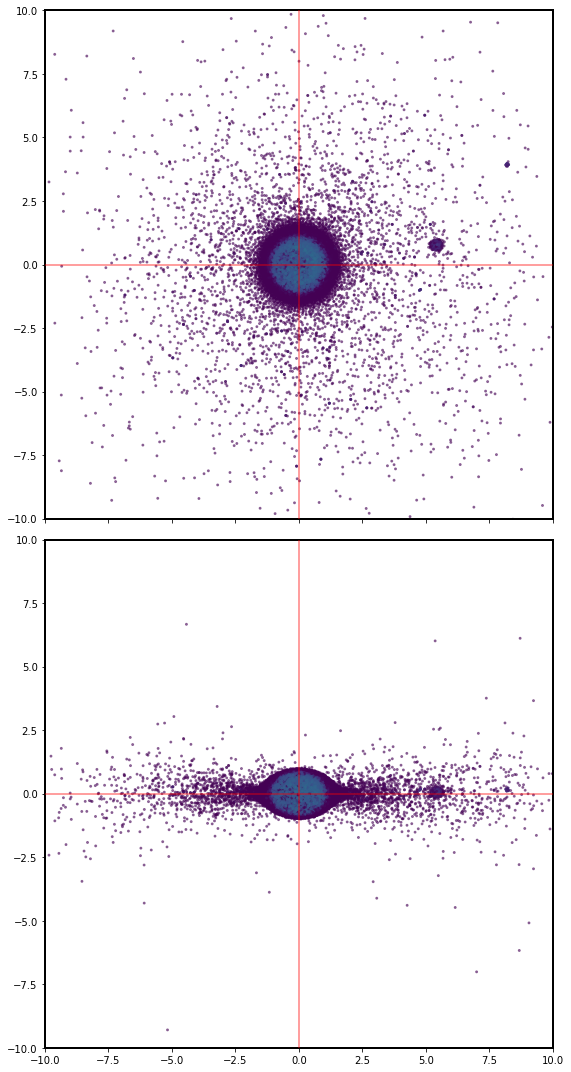

In [4]:
coll = pynbody.load(stdfile)

coll = center_on_largest_remnant(coll)

fig, axes = plt.subplots(2, 1, figsize=(10,15), sharex=True)

xlim = 10
ylim = 10
cvar = 'rho'

# Collision
x = coll['pos'][:,0]
y = coll['pos'][:,1]
z = coll['pos'][:,2]
c = coll[cvar]

del coll


ax = axes[0]

ax.set_aspect('equal')

ax.set_xlim(-xlim,xlim)
ax.set_ylim(-ylim,ylim)

ax.scatter(x, y, marker='.', s=15, c=c, alpha=0.5, zorder=1)

ax.axhline(y=0, color='red', alpha=0.5, zorder=5)
ax.axvline(x=0, color='red', alpha=0.5, zorder=5)


ax = axes[1]

ax.set_aspect('equal')

ax.set_xlim(-xlim,xlim)
ax.set_ylim(-ylim,ylim)

ax.scatter(x, z, marker='.', s=15, c=c, alpha=0.5, zorder=1)

ax.axhline(y=0, color='red', alpha=0.5, zorder=5)
ax.axvline(x=0, color='red', alpha=0.5, zorder=5)

plt.tight_layout()

plt.show()

## Disk finding algorithm

### Initial guess for planet mass and radius

The purpose of this initial guess is not to accurately recover the mass and radius, but rather to provide a conservative estimate of the radius. We can then exclude the particles interior to this radius in the analysis that follows. This will significantly reduce the computational cost in the steps that follow.

In [5]:
# Load collision
coll = pynbody.load(stdfile)

# Determine density cutoff for initial guess
rho_crit = np.percentile(coll['rho'].in_units('g cm**-3'), rho_perc)

# Mass of initial conservative estimate
M_est_init = np.sum(coll[coll['rho'].in_units('g cm**-3') > rho_crit]['mass'].in_units('5.9722e24 kg'))

# Calculate an initial guess for the planet radius using the critcal density
R_est_init = (3*M_est_init*C.MEARTH_G/(4*np.pi*rho_crit))**(1/3)/C.REARTH_CM

del coll

print(f"Cutoff density of all particles: {rho_crit:.4f} g/cm3")
print(f"\nM_est: {M_est_init:.4f} Earth masses")
print(f"R_est: {R_est_init:.4f} Earth radii")

Cutoff density of all particles: 3.2259 g/cm3

M_est: 0.7965 Earth masses
R_est: 1.1083 Earth radii


### Sliding window function for solid-body rotation

In [6]:
def sliding_window(stdfile, dev_perc, R_est_init, wsize=0.15, rmin=0.2):
    """Radially bins the deviation from solid body rotation to find a radius for the planet.
    
    Args:
        stdfile (str): Path to post-impact Tipsy file.
        dev_perc (float): Maximum absolute deviation from solid body rotation.
        R_est_init (float): Initial naive guess for planet radius (Earth radii).
        wsize (float): Sliding window size in Earth radii.
        rmin (float): Minimum radius when checking deviation (to avoid noise near center) in Earth radii.
        
    Returns:
        mids (1d array):  Midpoints of bins.
        means (1d array): Mean value of deltav in each bin.
        R_est (float):    Estimated radius of planet.
    """

    # Load snapshot and restrict to area around central planet
    s = pynbody.load(stdfile)
    
    # Number of radial bins depends on number of particles
    nbins = int(1e-2 * len(s))

    # In full analysis pipeline, this uses the PIDs of the largest remnant
    #s = center_snapshot(s, s)
    s = center_on_largest_remnant(s)
    
    # Only consider particles within this distance from center
    xmax = 5 * R_est_init

    # Constrain particles to region around planet (optimization)
    s = s[s['rxy'] < xmax]
    
    # Generate bins from 0 to <xmax> in Earth radii.
    bins = np.linspace(rmin, xmax, num=nbins)  
    
    binsize = bins[1] - bins[0]

    
    # Get midpoints of bins
    mids = []
    for i in range(1, len(bins)):
        mids.append((bins[i]+bins[i-1])/2)

        
    # Assign particles to bins    
    s['rbin'] = np.array(pd.cut(x=s['rxy'], bins=bins, labels=mids,
                                include_lowest=True))

    
    rvals = []
    vvals = []
    dvals = []

    # Initialize radius estimate
    R_est = 0

    # Counters on which radius search will be stopped
    empty_cnt = 0
    exceed_cnt = 0


    # Traverse radial bins outward
    for r in sorted(mids):

        # Start of sliding window
        wmin = np.max([0.5*rmin, r-wsize])

        # Midpoint of sliding window
        wmid = (wmin + r) / 2

        # Get slice corresponding to sliding window
        swin = s[(s['rxy'] > wmin) & (s['rxy'] <= r)]

        # How many particles in the sliding window?
        nwin = len(swin)

        if nwin == 0:
            print('[ERROR] Sliding window is empty! Try reducing radial resolution.')
            
        # Median rotation rate in sliding window (Hz)
        # This is the expected rotation rate in the current bin
        omega_exp = np.median(swin['vt'].in_units('km s**-1') / swin['rxy'].in_units('km'))

        # Delete window slice for performance
        del swin


        # Get slice corresponding to current bin
        sbin = s[s['rbin'] == r]

        # How many paticles in current bin?
        nbin = len(sbin)

        # If bin is empty, assume that current value of r is radius.
        if len(sbin) == 0:
            empty_cnt += 1
            if empty_cnt > 2:
                print(f"Three bins in a row were empty! Setting radius to {r-(2*binsize)}")
                return rvals, vvals, dvals, r-(2*binsize)
            continue
        else:
            empty_cnt = 0
            
        
        # Median transverse velocity
        vt = np.median(sbin['vt'].in_units('km s**-1'))


        # Expected transverse velocity for each particle in bin assuming solid-body rotation
        sbin['vt_exp'] = sbin['rxy'].in_units('km') * omega_exp

        # Fractional deviation from expected rotation rate for each particle in bin
        sbin['vt_dev'] = (sbin['vt'].in_units('km s**-1') - sbin['vt_exp']) / sbin['vt_exp']
        
        # Median fractional transverse velocity deviation in current bin
        ftvd = np.median(sbin['vt_dev'])

        rvals.append(r)
        vvals.append(vt)
        dvals.append(ftvd)


        if r < rmin:

            R_est = r

        elif abs(ftvd) > dev_perc:

            exceed_cnt += 1

            if exceed_cnt > 2:

                print(f"Three bins in a row exceeded the fractional transverse velocity tolerance! Setting radius to {r-(2*binsize)}")

                return rvals, vvals, dvals, r-(2*binsize)

        else:
            exceed_cnt = 0

        del sbin

    print("\t[ERROR] Disk finder was unable to estimate the planet's radius!")

    return rvals, vvals, dvals, np.nan

### Determine planetary radius

In [7]:
dev_perc = 0.05
r_min = 0.2   # R_Earth
w_size = 0.15  # R_Earth

bins, vels, means, R_est = sliding_window(stdfile, dev_perc, R_est_init,
                                          wsize=w_size, rmin=r_min)

Three bins in a row exceeded the fractional transverse velocity tolerance! Setting radius to 1.849002554834163


In [8]:
# Load snapshot and restrict to area around central planet
s = pynbody.load(stdfile)

s = center_on_largest_remnant(s)

planet = s[s['r'].in_units('6.3710084e3 km') <= R_est]

debris = s[s['r'].in_units('6.3710084e3 km') > R_est]

M_p = float(np.sum(planet['mass'].in_units('5.9722e24 kg')))
M_ej = float(np.sum(debris['mass'].in_units('5.9722e24 kg')))

del s, planet, debris

print(f"\nPlanet\nM_p = {M_p:.4f} Earth masses")
print(f"R_p = {R_est:.4f} Earth radii")
print(f"\nEjecta\nM_d = {M_ej:.4f} Earth masses")


Planet
M_p = 0.9984 Earth masses
R_p = 1.8490 Earth radii

Ejecta
M_d = 0.0581 Earth masses


### Plot disk finder results

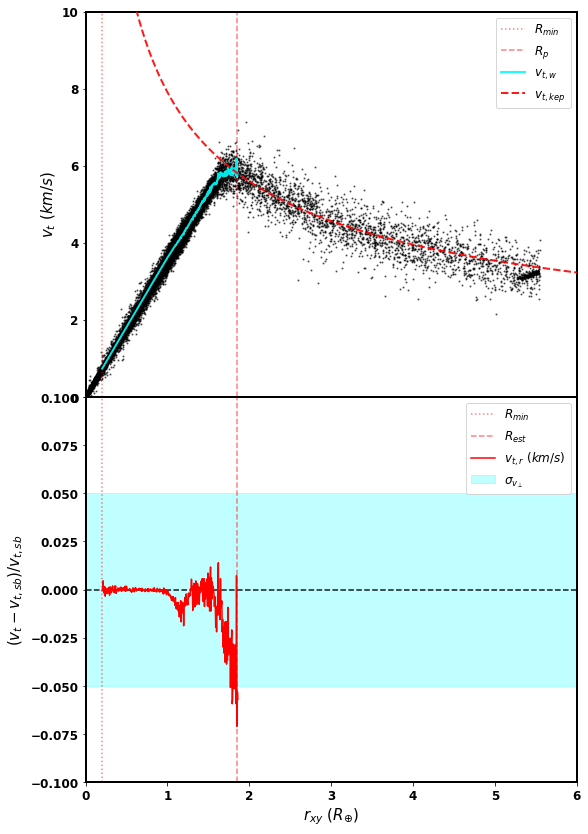

In [9]:
# Load snapshot and restrict to area around central planet
s = pynbody.load(stdfile)

s = center_on_largest_remnant(s)

s = s[s['rxy'] < 5 * R_est_init]


# Figure parameters
a4_inches = (8.268,11.693)

fig, axes = plt.subplots(2, 1, figsize=a4_inches)

fs_axlab = 15

xlim = 6


# TOP PANEL
ax = axes[0]

ax.set_xlim(0, xlim)
ax.set_ylim(0, 10)

ax.set_xticklabels([])

ax.set_ylabel(r'$v_{t}$ $(km/s)$', fontsize=fs_axlab)

x = s['rxy'].in_units('6.3710084e3 km')  # Earth radii
y = s['vt'].in_units('km s**-1')         # Hz


ax.axvline(x=r_min, linestyle=':', color='red', alpha=0.5, label='$R_{min}$')
ax.axvline(x=R_est, linestyle='--', color='red', alpha=0.5, label='$R_{p}$')

ax.scatter(x, y, marker='.', s=5, c='black', alpha=0.5, zorder=1, rasterized=True)


ax.plot(bins, vels, linewidth=2, linestyle='-',
        color='cyan', alpha=0.9, zorder=5,
        label=r"$v_{t,w}$")


# Plot Keplerian velocity curve
kepx = np.linspace(0.1, 10.0, num=1000)

kepy = [orbital_velocity(float(M_p) * C.MEARTH_KG, r * C.REARTH_M) for r in kepx]

ax.plot(kepx, kepy, linewidth=2, linestyle='--',
        color='red', alpha=0.9, zorder=5,
        label=r"$v_{t,kep}$")


# Legend
ax.legend(prop={'size': fontsize})


# BOTTOM PANEL
ax = axes[1]

ax.set_xlim(0, xlim)
ax.set_ylim(-0.1, 0.1)

ax.set_xlabel(r'$r_{xy}$ $(R_{\oplus})$', fontsize=fs_axlab)
ax.set_ylabel(r'$(v_{t} - v_{t,sb}) / v_{t,sb}$', fontsize=fs_axlab)

ax.axvline(x=r_min, linestyle=':', color='red', alpha=0.5, label='$R_{min}$')
ax.axvline(x=R_est, linestyle='--', color='red', alpha=0.5, label=r'$R_{est}$')

ax.fill_between(np.linspace(0, xlim, num=10), -dev_perc, dev_perc,
                color='cyan', alpha=0.25, label='$\sigma_{v_{\perp}}$')

ax.axhline(y=0, linestyle='--', color='black', alpha=0.9)


ax.plot(bins, means, color='red', label=r"$v_{t,r}$ $(km/s)$")


ax.legend(prop={'size': fontsize})


for ax in axes:
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight('bold')


plt.tight_layout()

plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

### Differentiate disk from ejecta

In this step, similar to other disk finders, the algorithm calculates the orbit of the disk and ejecta particles. If the periapsis of a particle is within the planetary radius, it is assigned to the planet.

In [10]:
idx_p    = []
idx_disk = []
idx_ej   = []


coll = pynbody.load(stdfile)

coll = center_on_largest_remnant(coll)


central_mass = M_p * C.MEARTH_KG

ct = 0

for idx in range(0, len(coll)):
    
    r_i   = coll['r'][idx]
    rxy_i = coll['r'][idx]
    
    if r_i < R_est:
        idx_p.append(idx)
        
    else:
    
        mass = coll['mass'].in_units('kg')[idx]

        pos = np.array(coll['pos'].in_units('m')[idx])

        vel = np.array(coll['vel'].in_units('m s**-1')[idx])

        
        # Compute orbits
        a, e, i, Omega, omega = cart2kep(pos, vel, mass, central_mass)

        a /= 6.3710084e6  # m -> Earth radii
    
    
        # Calculate periastron distance
        r_peri = a * (1.0 - e)
        
        
        if e >= 1.0:
            idx_ej.append(idx)
        
        elif r_peri <= R_est:
            idx_p.append(idx)
            ct += 1
            
        else:
            idx_disk.append(idx)
    

if len(idx_p) > 0:
    planet = coll[idx_p]
else:
    planet = None

if len(idx_disk) > 0:
    disk = coll[idx_disk]
else:
    disk = None
    
if len(idx_ej) > 0:
    ejecta = coll[idx_ej]
else:
    ejecta = None

del coll

### Fluid Roche limit

Here we simply calculate the theoretical fluid Roche limit for plotting in the next step.

In [11]:
rho_p = np.median(planet['rho'].in_units('g cm**-3'))

rho_sat = 1.0  # g/cm3

R_roche = 2.44 * R_est * (rho_p / rho_sat)**(1/3)

print(f"Fluid Roche limit = {R_roche:.6f} Earth radii")

Fluid Roche limit = 7.164279 Earth radii


### Summary of disk finder results

In [12]:
if planet:
    M_planet = np.sum(planet['mass'].in_units('5.9722e24 kg'))
    J_planet = angular_momentum(planet)
    omega = np.median(planet['vt'].in_units('km s**-1') / planet['rxy'].in_units('km'))
    P_rot = rotation_period(omega)
else:
    M_planet = 0
    J_planet = 0
    omega = np.nan
    P_rot = np.nan


if disk:
    M_disk = np.sum(disk['mass'].in_units('5.9722e24 kg'))
    J_disk = angular_momentum(disk)
else:
    M_disk = 0
    J_disk = 0


if ejecta:
    M_ejecta = np.sum(ejecta['mass'].in_units('5.9722e24 kg'))
    J_ejecta = angular_momentum(ejecta)
else:
    M_ejecta = 0
    J_ejecta = 0


# System
#print(f"Total mass = {M_tot:.6f} Earth masses")
print(f"Fluid Roche limit = {R_roche:.6f} Earth radii")

# Planet
print(f"\nPlanet:\nM = {M_planet:.6f} Earth masses")
print(f"R = {R_est:.6f} Earth radii (equatorial)")
print(f"J = {J_planet:.2e} J-s ({J_planet/C.J_EM:.4f} J_EM)")
print(f"omega = {omega:.8f} Hz")
print(f"P_rot = {P_rot:.4f} hrs")

# Disk
print(f"\nDisk:\nM = {M_disk:.6f} Earth masses ({M_disk/0.0123:.6f} Lunar masses)")
print(f"J = {J_disk:.2e} J-s ({J_disk/C.J_EM:.4f} J_EM)")

# Ejecta
print(f"\nEjecta:\nM = {M_ejecta:.6f} Earth masses")
print(f"J = {J_ejecta:.2e} J-s ({J_ejecta/C.J_EM:.4f} J_EM)")

Fluid Roche limit = 7.164279 Earth radii

Planet:
M = 1.004414 Earth masses
R = 1.849003 Earth radii (equatorial)
J = 7.16e+34 J-s (1.9895 J_EM)
omega = 0.00056717 Hz
P_rot = 3.0772 hrs

Disk:
M = 0.044667 Earth masses (3.631493 Lunar masses)
J = 3.03e+34 J-s (0.8414 J_EM)

Ejecta:
M = 0.007417 Earth masses
J = 7.21e+33 J-s (0.2003 J_EM)


### Plot planet, disk, and ejecta

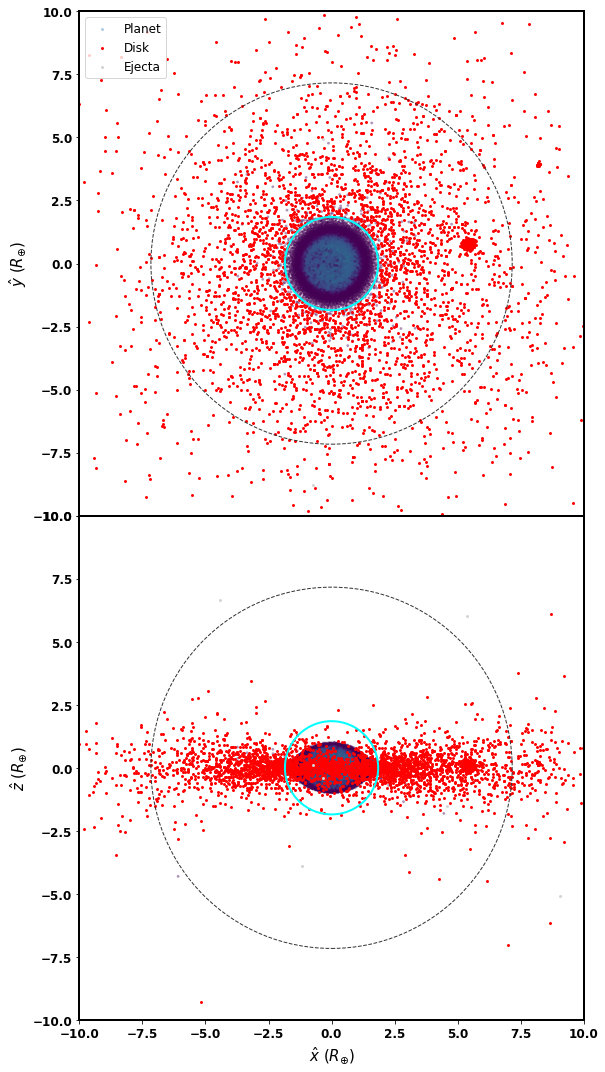

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(10,15), sharex=True)

xlim = 10
ylim = xlim
cvar = 'rho'


ax = axes[0]

ax.set_aspect('equal')

#ax.set_xlabel('$\hat{x}$ $(R_{\oplus})$', fontsize=fs_axlab)
ax.set_ylabel('$\hat{y}$ $(R_{\oplus})$', fontsize=fs_axlab)

ax.set_xlim(-xlim,xlim)
ax.set_ylim(-ylim,ylim)


# Planet
if planet:
    
    xplanet = np.array(planet['pos'])[:,0]
    yplanet = np.array(planet['pos'])[:,1]
    zplanet = np.array(planet['pos'])[:,2]
    cplanet = planet[cvar]
    
    ax.scatter(xplanet, yplanet, marker='.', s=15, c=cplanet, alpha=0.3, zorder=1, label='Planet')
    
# Disk
if disk:

    xdisk = np.array(disk['pos'])[:,0]
    ydisk = np.array(disk['pos'])[:,1]
    zdisk = np.array(disk['pos'])[:,2]
    cdisk = disk[cvar]

    ax.scatter(xdisk, ydisk, marker='.', s=15, c='red', zorder=1, label='Disk')

# Ejecta
if ejecta: 
    
    xejecta = np.array(ejecta['pos'])[:,0]
    yejecta = np.array(ejecta['pos'])[:,1]
    zejecta = np.array(ejecta['pos'])[:,2]
    cejecta = ejecta[cvar]
    
    ax.scatter(xejecta, yejecta, marker='.', s=15, c='lightgray', zorder=1, label='Ejecta')

    
R2 = plt.Circle((0.0, 0.0), R_est, facecolor='none', edgecolor='cyan', linewidth=2, zorder=9)

circ2 = ax.add_artist(R2)

Roche = plt.Circle((0.0, 0.0), R_roche, facecolor='none', edgecolor='#333333',
                   linewidth=1, linestyle='--', zorder=9, label=r"Fluid Roche limit ($\rho = 1$ $g/cm^3$)")

circ3 = ax.add_artist(Roche)

ax.legend(prop={'size': fontsize})


ax = axes[1]

ax.set_aspect('equal')

ax.set_xlabel(r"$\hat{x}$ $(R_{\oplus})$", fontsize=fs_axlab)
ax.set_ylabel(r"$\hat{z}$ $(R_{\oplus})$", fontsize=fs_axlab)

ax.set_xlim(-xlim,xlim)
ax.set_ylim(-ylim,ylim)

if planet:
    ax.scatter(xplanet, zplanet, marker='.', s=15, c=cplanet, alpha=0.3, zorder=1)
if disk:
    ax.scatter(xdisk, zdisk, marker='.', s=15, c='red', zorder=1)
if ejecta:
    ax.scatter(xejecta, zejecta, marker='.', s=15, c='lightgray', zorder=1)


Roche = plt.Circle((0.0, 0.0), R_roche, facecolor='none', edgecolor='#333333',
                   linewidth=1, linestyle='--', zorder=9, label=r"Fluid Roche limit ($\rho = 1$ $g/cm^3$)")

circ3 = ax.add_artist(Roche)


R2 = plt.Circle((0.0, 0.0), R_est, facecolor='none', edgecolor='cyan', linewidth=2, zorder=9)
circ2 = ax.add_artist(R2)


E2 = Ellipse((0.0, 0.0), 2*R_est, 2*R_est/1.5,
             facecolor='none', edgecolor='green',
             linewidth=2, zorder=9)

for ax in axes:
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight('bold')


plt.tight_layout()

plt.subplots_adjust(wspace=0, hspace=0)

plt.show()